# Agrammatic and paragrammatic aphasias

### Set-up

In [1]:
###########################################
###########################################

import random
import numpy as np
from copy import deepcopy
from importlib import reload 

import syntactic_wm as cjn ## Our model
reload(cjn)

################
## Parameters ##
################
num_steps = 5 # number of time steps taken by each word input.
head = 1 # number of time steps buffering the front of each sentence.
tail = 20 # number of time steps buffering the end of each sentence.
no_periods = 1 # number of epochs each sentence is presented to the model.

lambda_cc = 50 # learning rate of short-term synaptic plasticity amongst role neurons.
lambda_cf = 1 # learning rate of short-term synaptic plasticity between role and word neurons.

tau = 0.5 # modifies change in firing rate at each time step to simulate continuous time.

beta = 1 # decay factor of firing rates.

n_word_neurons = 15 # number of word neurons initialised (f)
n_role_neurons = 10 # number of role neurons initialised (c)

gamma = 1 # factor dampening connectivity amongst role neurons.

epsilon_cc = 0.75 # the ceiling of c-c connections when without long-term encoding. 
k_cc = 4 # negative bias, i.e. negative k_cc is the floor of c-c connections.

epsilon_cf = 1.5 # the ceiling of c-f connections when without long-term encoding. 
k_cf = 1 # negative bias, i.e. negative k_cf is the floor of c-f connections.

h = 6 # normalising factor for inhibition between c-f connections.

W_mc = 2 # connectivity between morph and role neurons (non-encodable)
W_mm = -10 # conneectivity between morpheme neurons to itself (non-encodable)

W_ff = -1.5  # connectivity amongst word neurons (non-encodable)

unified_noise = 0 # noise level if noise is present
cc_noise = False # any noise amongst role neurons
wc_noise = False # any noise between role and word neurons

k_L_cc = 8.25 # long-term encoding amongst role neurons 
k_L_cf = 1.7 # long-term encoding between role and word neurons

k_L_cf_closed_class = 1.45 # long-term encoding between role and word neurons when the word belongs to a closed class

auto_gramm = True # this flag moves the direct sensory input alpha to within the sigmoid function

# Flag to induce lesion in paragrammatic aphasia
wernic = False # flag that introduces noise into long-term encoding between word and role neurons. It will also switch lambda_cf to zero.


## Base Control (Sequential input only)

First, we test that the model (with the current settings) can recall successfully with sequential input. <br>
Note two words are defined to be closed-class words.

In [2]:
seed_ = 0 # setting default random seed
np.random.seed(seed_)
random.seed(seed_)

LT_wc_knowledge = [[0,0],[1,0],[2,1],[3,1],[4,2],[5,2],[6,3],[7,4],[8,4],[9,5],[10,5],[11,6],[12,7],[13,7]] # long term encodings of word-to-role connections
LT_cc_knowledge = [[0,1,2,3,4],[0,1,5,6,7]] # long term encodings amongst role neurons
closed_class_word_roles = [[6,3],[11,6]] # define the closed class words

# building the sentence
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0))
for n in range(num_steps): sentence.append(cjn.in_in(word=3))
for n in range(num_steps): sentence.append(cjn.in_in(word=10))
for n in range(num_steps): sentence.append(cjn.in_in(word=11))
for n in range(num_steps): sentence.append(cjn.in_in(word=13))
for n in range(tail): sentence.append(cjn.in_in())

## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc,
                       cf_max_connection = epsilon_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm,
                       closed_class_learnt_weight = k_L_cf_closed_class - k_cf,
                       closed_class_word_roles = closed_class_word_roles,
                       auto_gramm = auto_gramm,
                       wernic = wernic
                      )


# running the encoding phase
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  46
********************


### Visualisation of encoding

Again, we can visualise the learning that occurred during the encoding phase. <br>

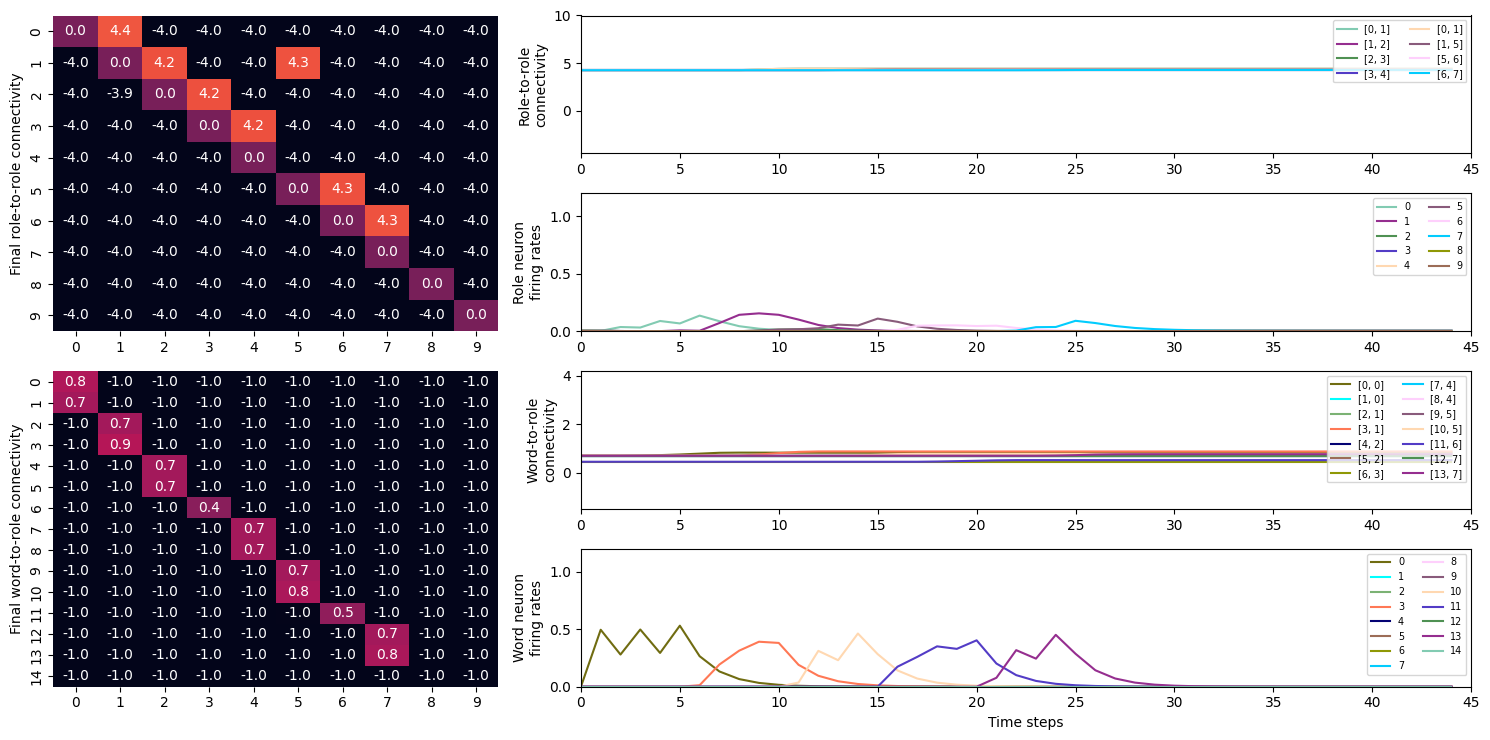

In [3]:
cjn.plot_results(sentence, epsilon_cc+k_L_cc, -k_cc, epsilon_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx)


### Recall of the encoded sentence

We test that the network is able to recall the above encoded sentence.

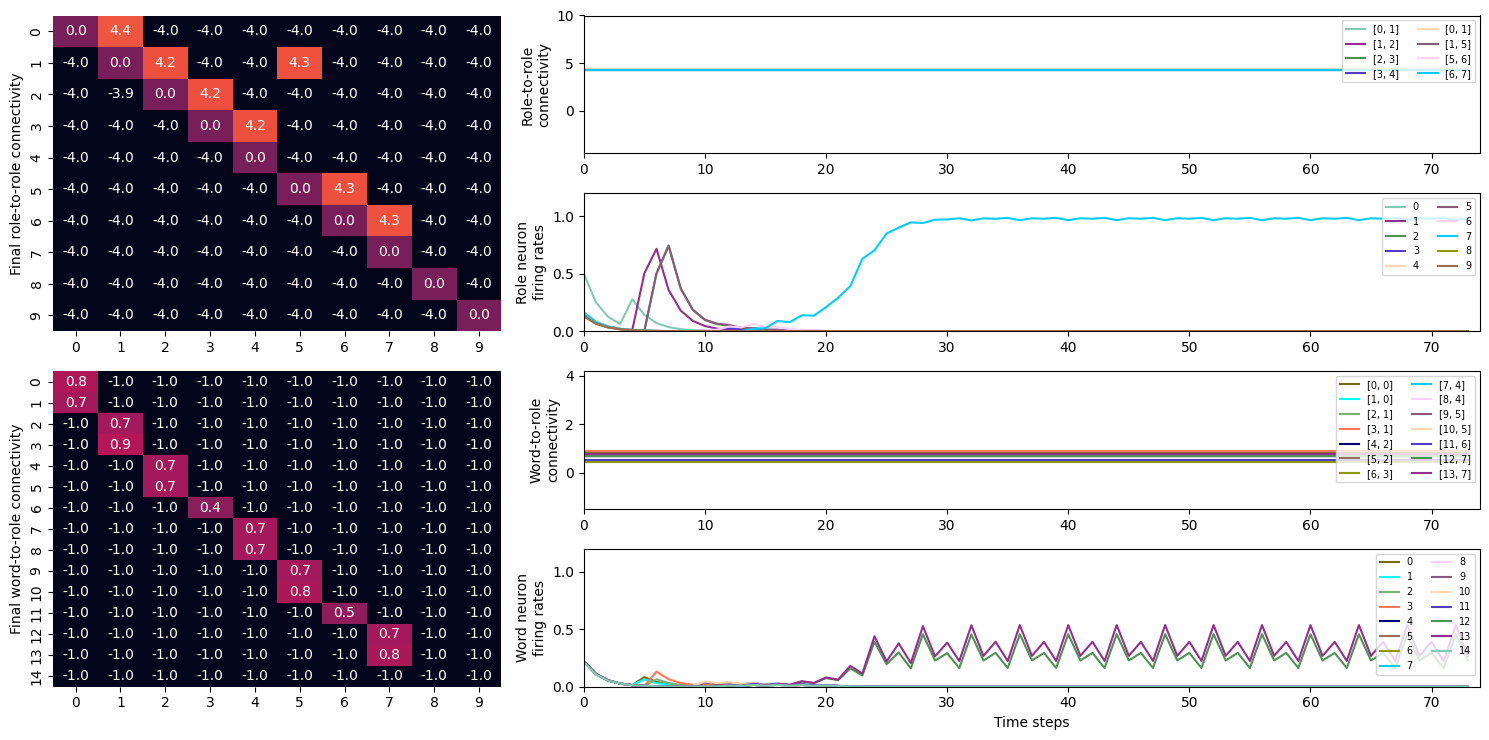

The final recall output is: 
[[0.0], [3.0], [10.0], [11.0], [13.0]]


In [4]:
WM_r = deepcopy(WM_ori) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 75 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc+k_L_cc, -k_cc, epsilon_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))

## Simulation 7 - Control (with serialization)

Next, we demonstrate that the network can produce grammatical output when the input includes simultaneous input demonstrating serialisation, and also the exclusion of closed-class word in the input.

In [5]:
seed_ = 0 # setting default random seed
np.random.seed(seed_)
random.seed(seed_)

LT_wc_knowledge = [[0,0],[1,0],[2,1],[3,1],[4,2],[5,2],[6,3],[7,4],[8,4],[9,5],[10,5],[11,6],[12,7],[13,7]] # long term encodings of word-to-role connections
LT_cc_knowledge = [[0,1,2,3,4],[0,1,5,6,7]] # long term encodings amongst role neurons
closed_class_word_roles = [[6,3],[11,6]] # define the closed class words

# building the sentence
# note the closed class word is missing in this input
# feel free to try with different words and branching as defined by the long-term encodings!!
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0))
for n in range(num_steps): sentence.append(cjn.in_in(word=3))
for n in range(20): sentence.append([cjn.in_in(word=10),cjn.in_in(word=13)]) # simultaneous input fo two different words
for n in range(tail): sentence.append(cjn.in_in())

## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc,
                       cf_max_connection = epsilon_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm,
                       closed_class_learnt_weight = k_L_cf_closed_class - k_cf,
                       closed_class_word_roles = closed_class_word_roles,
                       auto_gramm = auto_gramm
                      )


# running the encoding phase
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  51
********************


### Visualisation of encoding

We can visualise the learning that occurred during the encoding phase. <br>
In particular, we note that there is serialisation due to the sensory direct input $\alpha$ is being shifted into the $\sigma$ function.

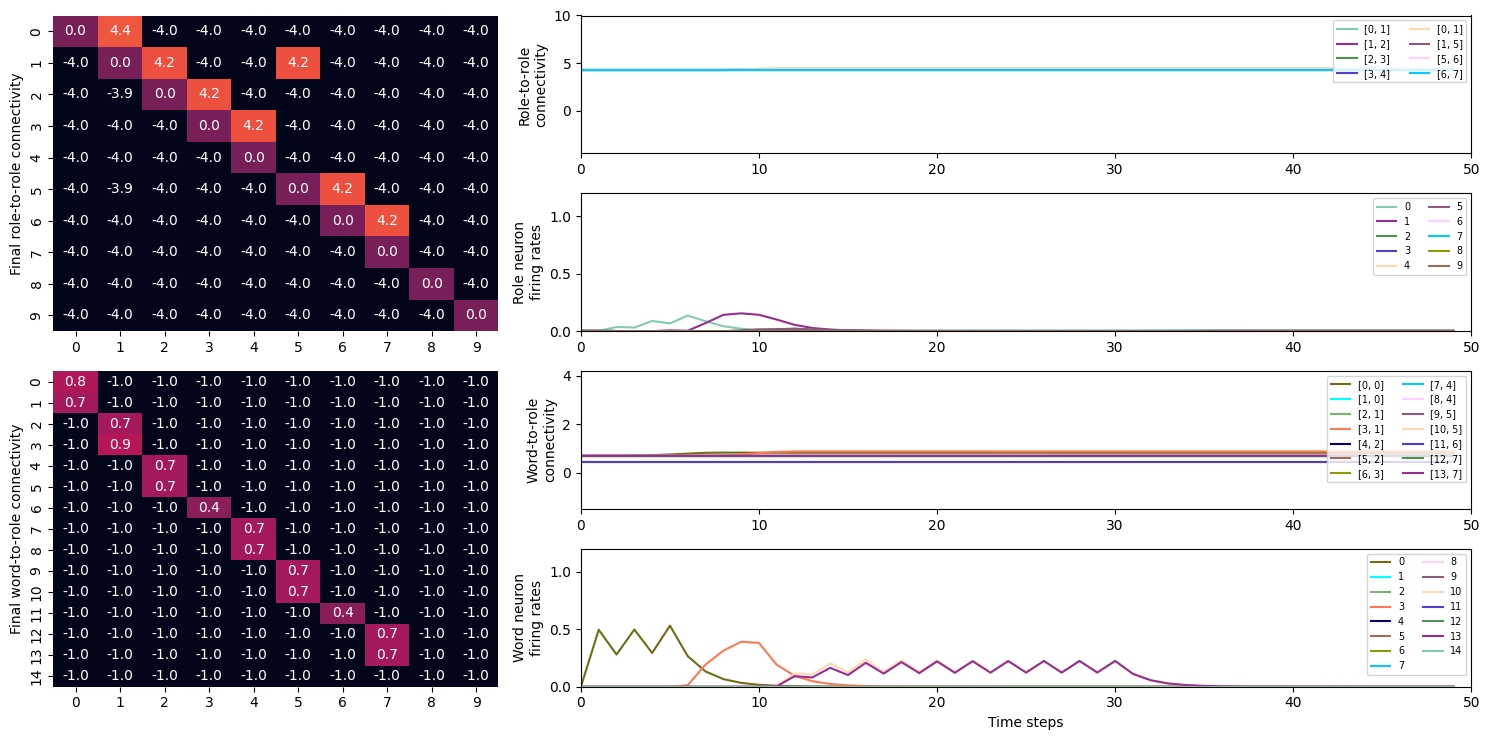

In [6]:
cjn.plot_results(sentence, epsilon_cc+k_L_cc, -k_cc, epsilon_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx)


### Recall of the encoded sentence with serialisation

We test that the network is able to recall the above encoded sentence with the serialisation and the missing closed-class word.

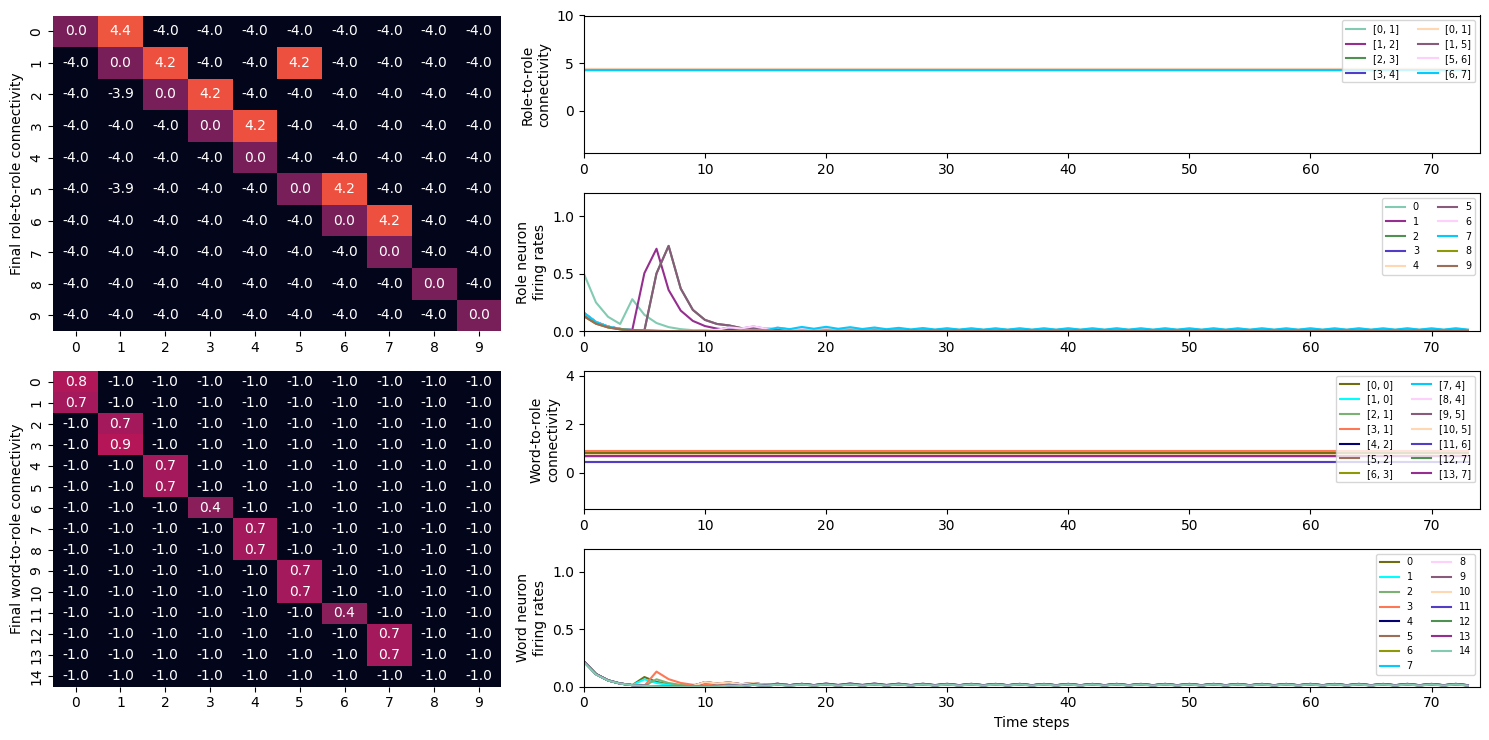

The final recall output is: 
[[0.0], [3.0], [10.0], [11.0], [13.0]]


In [7]:
WM_r = deepcopy(WM_ori) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 75 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc+k_L_cc, -k_cc, epsilon_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))

### Simulation 8 - Demonstrating agrammatic aphasia

Following the control simulation above, we demonstrate that with the introduction of noise, the network produces recall similar to agrammatic aphasia.

In [8]:
seed_ = 3 # setting default random seed
np.random.seed(seed_)
random.seed(seed_)

LT_wc_knowledge = [[0,0],[1,0],[2,1],[3,1],[4,2],[5,2],[6,3],[7,4],[8,4],[9,5],[10,5],[11,6],[12,7],[13,7]] # long term encodings of word-to-role connections
LT_cc_knowledge = [[0,1,2,3,4],[0,1,5,6,7]] # long term encodings amongst role neurons
closed_class_word_roles = [[6,3],[11,6]] # define the closed class words

wernic = False

## adding noise to simulate agrammatic aphasia
unified_noise = 0.25
cc_noise = True
wc_noise = False
mw_noise = False

# building the sentence
# note the closed class word is missing in this input
# feel free to try with different words and branching as defined by the long-term encodings!!
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0))
for n in range(num_steps): sentence.append(cjn.in_in(word=3))
for n in range(20): sentence.append([cjn.in_in(word=10),cjn.in_in(word=13)]) # simultaneous input fo two different words
for n in range(tail): sentence.append(cjn.in_in())

## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc,
                       cf_max_connection = epsilon_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm,
                       closed_class_learnt_weight = k_L_cf_closed_class - k_cf,
                       closed_class_word_roles = closed_class_word_roles,
                       auto_gramm = auto_gramm
                      )


# running the encoding phase
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  51
********************


### Visualisation of encoding

Again, we can visualise the learning that occurred during the encoding phase. <br>

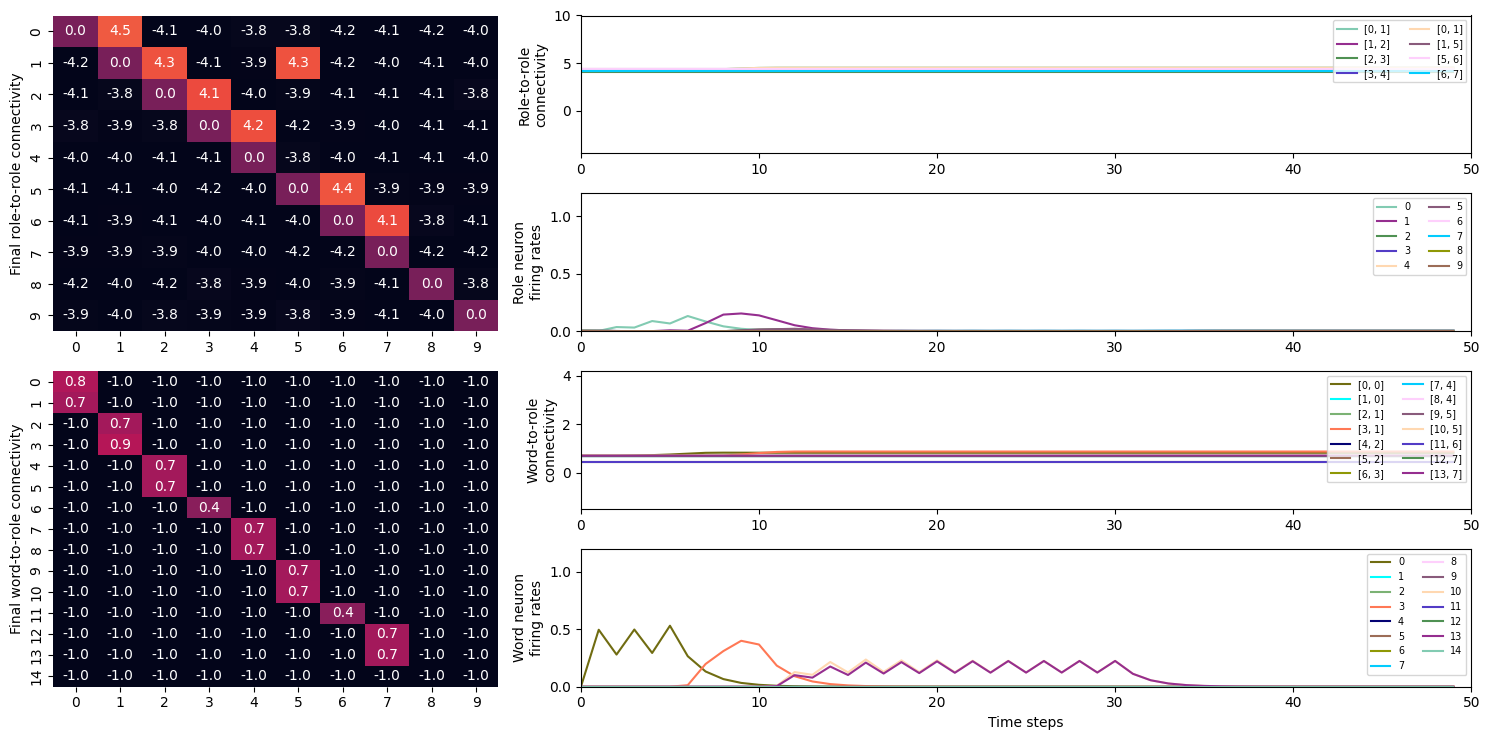

In [9]:
cjn.plot_results(sentence, epsilon_cc+k_L_cc, -k_cc, epsilon_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx)


### Recall of the encoded sentence showing agrammatic aphasia

The recalled sentence is missing the closed-class word while retaining the ability to serialise semantic input.

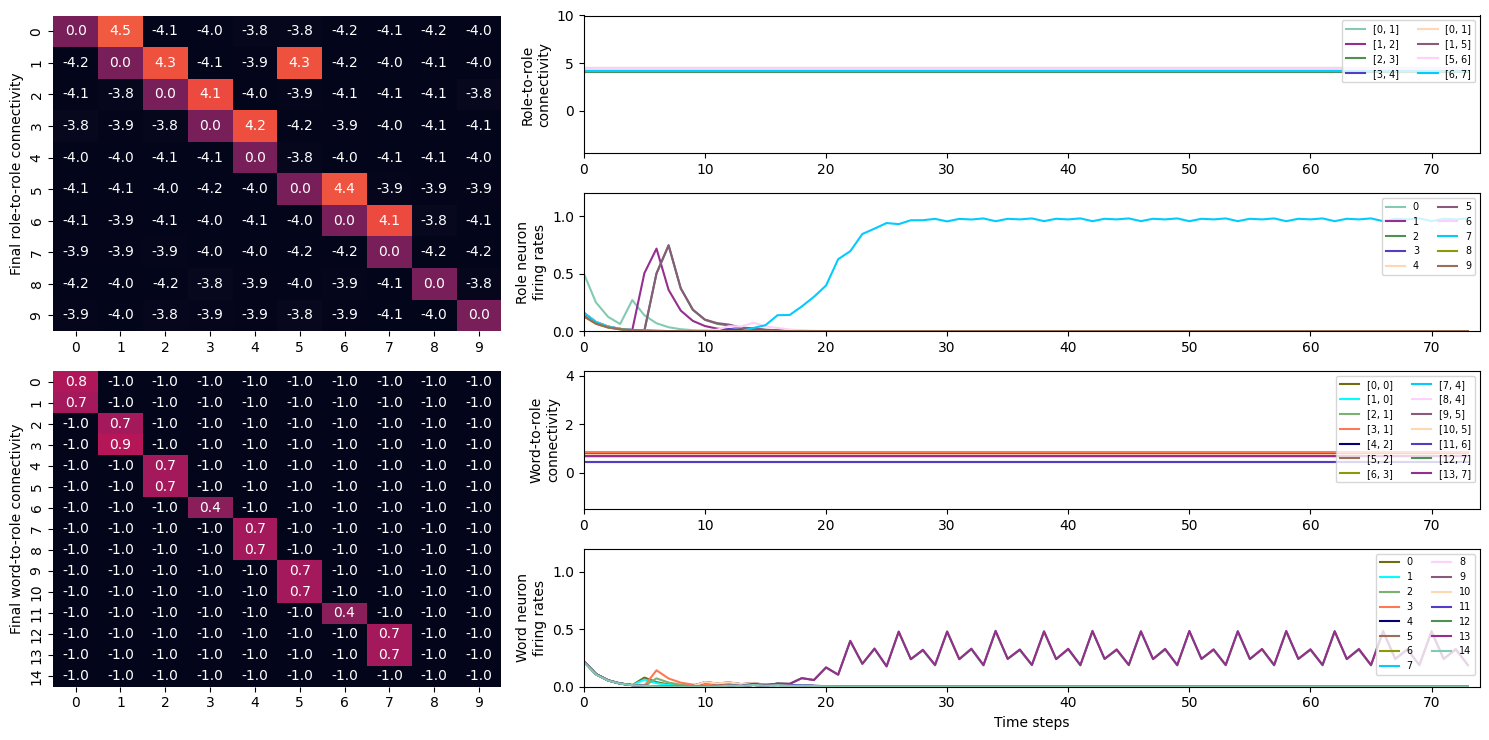

The final recall output is: 
[[0.0], [3.0], [10.0], [13.0]]


In [10]:
WM_r = deepcopy(WM_ori) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 75 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc+k_L_cc, -k_cc, epsilon_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))

## Simulation 9 - Paragrammatic aphasia

In the next simulation, we demonstrate that with the introduction of noise and switching of $\lambda^{fc}$ to 0, the network produces recall similar to paragrammtic aphasia. <br>
The sentence input is the same as in agrammatic aphasia above (i.e. with auto-serialization and exclusion of closed-class words)

In [11]:
# Different seeds will produce different recall output!
seed_ = 7 # setting default random seed
np.random.seed(seed_)
random.seed(seed_)

LT_wc_knowledge = [[0,0],[1,0],[2,1],[3,1],[4,2],[5,2],[6,3],[7,4],[8,4],[9,5],[10,5],[11,6],[12,7],[13,7]] # long term encodings of word-to-role connections
LT_cc_knowledge = [[0,1,2,3,4],[0,1,5,6,7]] # long term encodings amongst role neurons
closed_class_word_roles = [[6,3],[11,6]] # define the closed class words

wernic = True # flag that introduces noise into long-term encoding between word and role neurons. It will also switch lambda_cf to zero.

# turning off the noise that was turned on for agrammatic aphasia
unified_noise = 0
cc_noise = False
wc_noise = False
mw_noise = False

# building the sentence
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0))
for n in range(num_steps): sentence.append(cjn.in_in(word=3))
for n in range(20): sentence.append([cjn.in_in(word=10),cjn.in_in(word=13)]) # simultaneous input fo two different words
for n in range(tail): sentence.append(cjn.in_in())

## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc,
                       cf_max_connection = epsilon_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm,
                       closed_class_learnt_weight = k_L_cf_closed_class - k_cf,
                       closed_class_word_roles = closed_class_word_roles,
                       auto_gramm = auto_gramm,
                       wernic = wernic
                      )


# running the encoding phase
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)


********************
Epoch = 1
Number of recorded time steps:  51
********************


### Visualisation of encoding

We can visualise the learning that occurred during the encoding phase. <br>

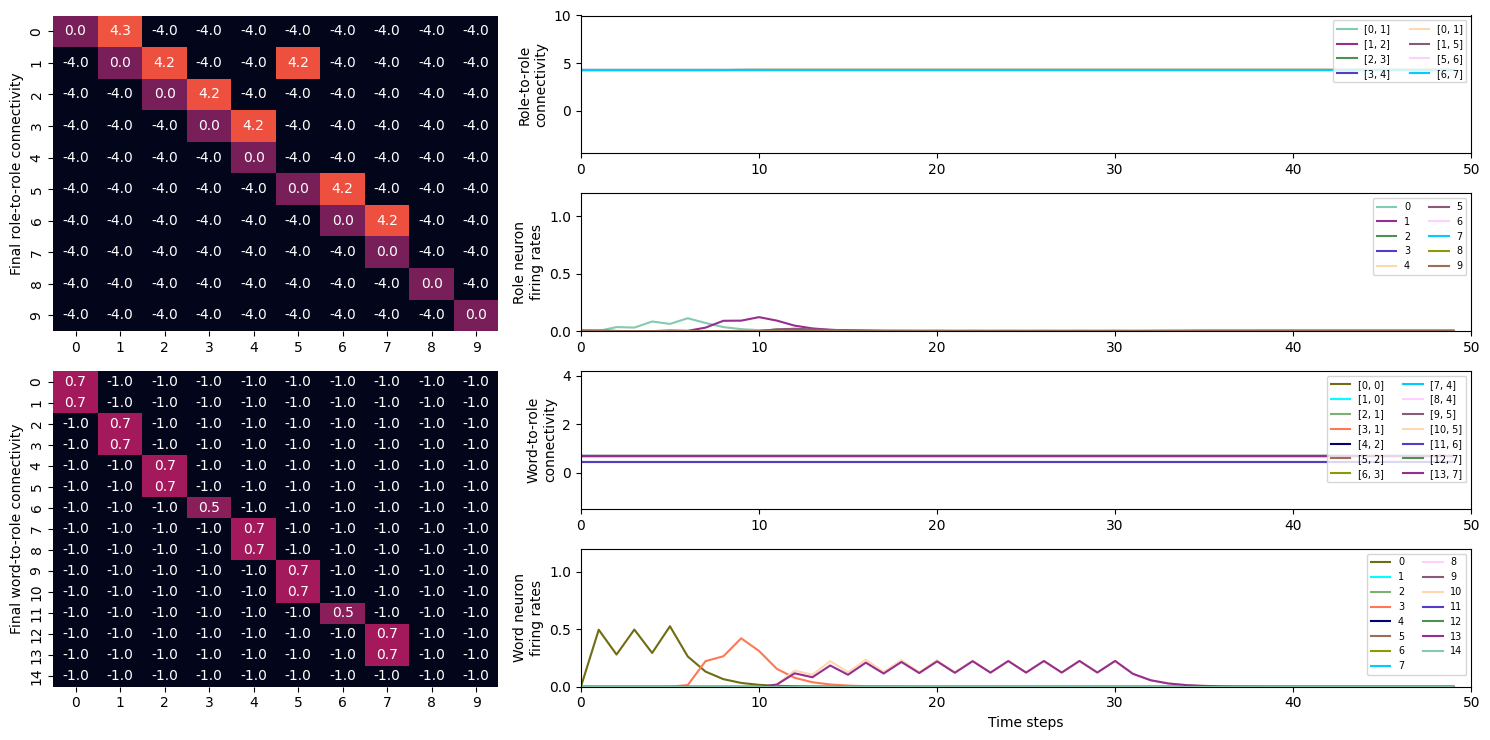

In [12]:
cjn.plot_results(sentence, epsilon_cc+k_L_cc, -k_cc, epsilon_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx)


### Recall of the encoded sentence showing paragrammatic aphasia

The recalled sentence has preserved syntax but missing original words in the input sentence. <br>
Trying different random seeds will give rise to different results.

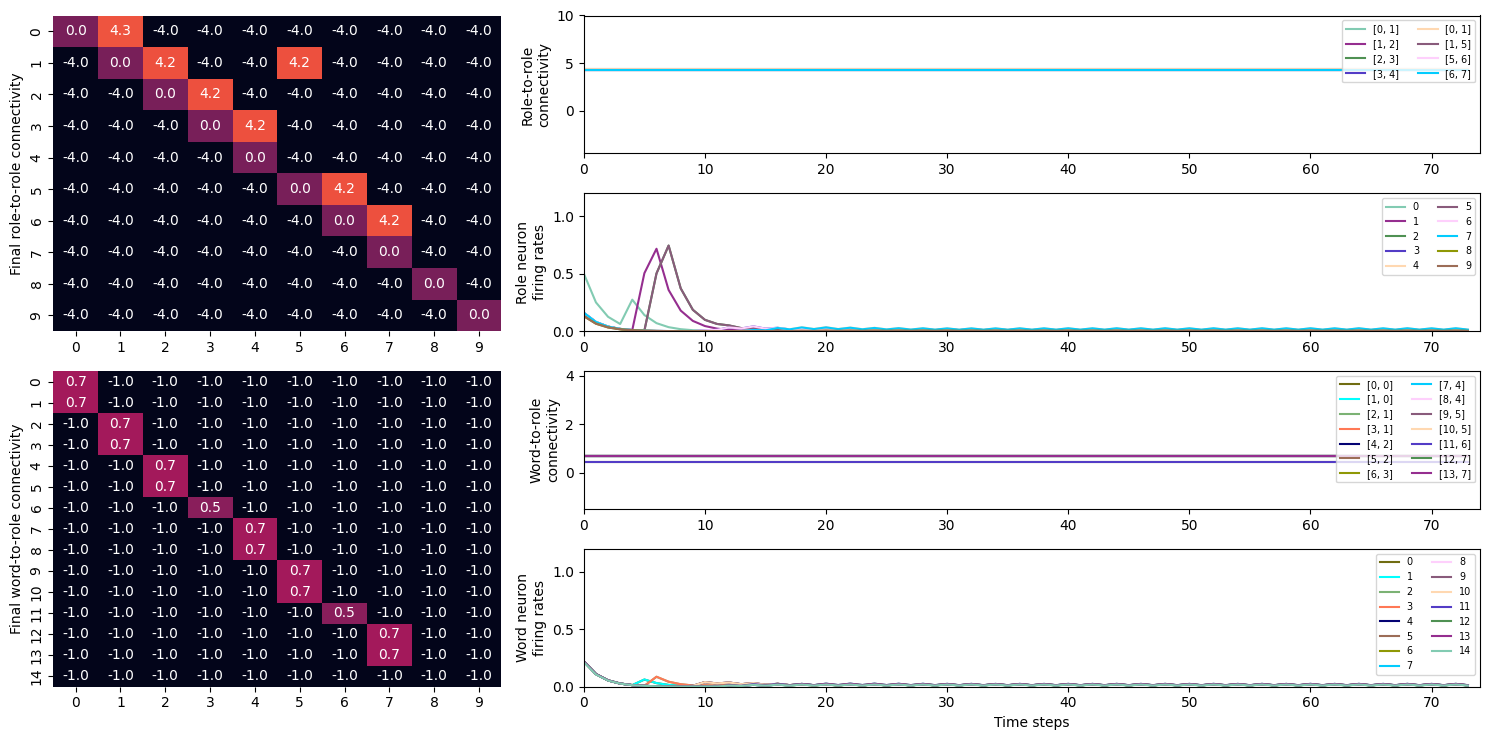

The final recall output is: 
[[1.0], [3.0], [4.0], [6.0], [8.0]]


In [13]:
WM_r = deepcopy(WM_ori) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 75 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc+k_L_cc, -k_cc, epsilon_cf+k_L_cf, -k_cf, LT_cc_knowledge, LT_wc_knowledge, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))

## Repeats with different random seeds

In [99]:
# # Repeats of paragrammatic aphasia
# LT_wc_knowledge = [[0,0],[1,0],[2,1],[3,1],[4,2],[5,2],[6,3],[7,4],[8,4],[9,5],[10,5],[11,6],[12,7],[13,7]] # long term encodings of word-to-role connections
# LT_cc_knowledge = [[0,1,2,3,4],[0,1,5,6,7]] # long term encodings amongst role neurons
# closed_class_word_roles = [[6,3],[11,6]] # define the closed class words

# # list of all syntactic word pairs
# reference_list = [[0.0,2.0],[0.0,3.0],[1.0,2.0],[1.0,3.0],[2.0,4.0],[3.0,4.0],[2.0,5.0],[3.0,5.0],[4.0,6.0],[5.0,6.0],
#             [6.0,7.0],[6.0,8.0],[2.0,9.0],[3.0,9.0],[2.0,10.0],[3.0,10.0],[9.0,11.0],[10.0,11.0],[11.0,12.0],[11.0,13.0]]

# syn_err_mat_p = np.zeros((50,1))
# word_err_mat_p = np.zeros((50,1))

# # building the sentence
# # note the closed class word is missing in this input
# # feel free to try with different words and branching as defined by the long-term encodings!!
# sentence = []
# for n in range(head): sentence.append(cjn.in_in())
# for n in range(num_steps): sentence.append(cjn.in_in(word=0))
# for n in range(num_steps): sentence.append(cjn.in_in(word=3))
# for n in range(20): sentence.append([cjn.in_in(word=10),cjn.in_in(word=13)]) # simultaneous input fo two different words
# for n in range(tail): sentence.append(cjn.in_in())

# def flatten(l):
#     return [item for sublist in l for item in sublist]

# for seed_ in range(50):
#     print('#'*30)
#     print('current seed is ' + str(seed_))

#     np.random.seed(seed_)
#     random.seed(seed_)

#     wernic = True

#     ## adding noise to simulate agrammatic aphasia
#     unified_noise = 0
#     cc_noise = False
#     wc_noise = False
#     mw_noise = False
    
#     syn_err = 0
#     word_err = 0

#     ## initialising the working memory model
#     WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
#                            cc_connectivity_factor = gamma,
#                            activation_decay = beta,
#                            LR_c = lambda_cc,
#                            LR_w = lambda_cf,
#                            cc_max_connection = epsilon_cc,
#                            cf_max_connection = epsilon_cf,
#                            n_word_neurons = n_word_neurons,
#                            time_factor = tau,
#                            LT_wc_knowledge = LT_wc_knowledge,
#                            cc_learnt_weight = k_L_cc - k_cc,
#                            cf_learnt_weight = k_L_cf - k_cf,
#                            input_node_connectivity = W_ff,
#                            LT_cc_knowledge = LT_cc_knowledge,
#                            cc_floor_weight = -k_cc, 
#                            cf_floor_weight = -k_cf,
#                            unified_noise = unified_noise,
#                            cc_noise = cc_noise,
#                            wc_noise = wc_noise,
#                            cf_conj_factor = h,
#                            mc_connectivity_factor = W_mc,
#                            mm_connectivity_factor = W_mm,
#                            closed_class_learnt_weight = k_L_cf_closed_class - k_cf,
#                            closed_class_word_roles = closed_class_word_roles,
#                            auto_gramm = auto_gramm,
#                            wernic = wernic
#                           )


#     # running the encoding phase
#     role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)

    
#     WM_r = deepcopy(WM_ori) # copy the encoded model
#     initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
#     n_steps = 75 # total number of time steps taken during recall

#     # building recall input with 5 initial time steps with input into the first role neuron and then no further input.
#     recall_input = []
#     for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
#     for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

#     # running the recall phase
#     cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

#     # Final recall determined by argmax at each time step
#     print('The final recall output is: ')
#     print(cjn.argmax_sentence(f_act_hx_r))
    
#     r_output = flatten(cjn.argmax_sentence(f_act_hx_r))
    
#     if len(r_output) > 1:
#         for output_n in range(len(r_output)-1):
#             output_pair = r_output[output_n:output_n+2]
#             for pair in range(len(reference_list)):
#                 if reference_list[pair] == output_pair:
#                     break
#                 if pair == len(reference_list)-1:
#                     syn_err += 1
                    
#     for word in r_output:
#         if word not in [0,3,10,11,13]:
#             word_err += 1
            
#     syn_err_mat_p[seed_,0] = syn_err
#     word_err_mat_p[seed_,0] = word_err

In [98]:
# # Repeats of agrammatic aphasia
# LT_wc_knowledge = [[0,0],[1,0],[2,1],[3,1],[4,2],[5,2],[6,3],[7,4],[8,4],[9,5],[10,5],[11,6],[12,7],[13,7]] # long term encodings of word-to-role connections
# LT_cc_knowledge = [[0,1,2,3,4],[0,1,5,6,7]] # long term encodings amongst role neurons
# closed_class_word_roles = [[6,3],[11,6]] # define the closed class words

# # list of all syntactic word pairs
# reference_list = [[0.0,2.0],[0.0,3.0],[1.0,2.0],[1.0,3.0],[2.0,4.0],[3.0,4.0],[2.0,5.0],[3.0,5.0],[4.0,6.0],[5.0,6.0],
#             [6.0,7.0],[6.0,8.0],[2.0,9.0],[3.0,9.0],[2.0,10.0],[3.0,10.0],[9.0,11.0],[10.0,11.0],[11.0,12.0],[11.0,13.0]]

# syn_err_mat_ag = np.zeros((50,1))
# word_err_mat_ag = np.zeros((50,1))

# # building the sentence
# # note the closed class word is missing in this input
# # feel free to try with different words and branching as defined by the long-term encodings!!
# sentence = []
# for n in range(head): sentence.append(cjn.in_in())
# for n in range(num_steps): sentence.append(cjn.in_in(word=0))
# for n in range(num_steps): sentence.append(cjn.in_in(word=3))
# for n in range(20): sentence.append([cjn.in_in(word=10),cjn.in_in(word=13)]) # simultaneous input fo two different words
# for n in range(tail): sentence.append(cjn.in_in())

# def flatten(l):
#     return [item for sublist in l for item in sublist]


# for seed_ in range(50):
#     print('#'*30)
#     print('current seed is ' + str(seed_))

#     np.random.seed(seed_)
#     random.seed(seed_)

#     wernic = False

#     ## adding noise to simulate agrammatic aphasia
#     unified_noise = 0.5
#     cc_noise = True
#     wc_noise = False
#     mw_noise = False

#     syn_err = 0
#     word_err = 0
    
#     ## initialising the working memory model
#     WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
#                            cc_connectivity_factor = gamma,
#                            activation_decay = beta,
#                            LR_c = lambda_cc,
#                            LR_w = lambda_cf,
#                            cc_max_connection = epsilon_cc,
#                            cf_max_connection = epsilon_cf,
#                            n_word_neurons = n_word_neurons,
#                            time_factor = tau,
#                            LT_wc_knowledge = LT_wc_knowledge,
#                            cc_learnt_weight = k_L_cc - k_cc,
#                            cf_learnt_weight = k_L_cf - k_cf,
#                            input_node_connectivity = W_ff,
#                            LT_cc_knowledge = LT_cc_knowledge,
#                            cc_floor_weight = -k_cc, 
#                            cf_floor_weight = -k_cf,
#                            unified_noise = unified_noise,
#                            cc_noise = cc_noise,
#                            wc_noise = wc_noise,
#                            cf_conj_factor = h,
#                            mc_connectivity_factor = W_mc,
#                            mm_connectivity_factor = W_mm,
#                            closed_class_learnt_weight = k_L_cf_closed_class - k_cf,
#                            closed_class_word_roles = closed_class_word_roles,
#                            auto_gramm = auto_gramm,
#                            wernic = wernic
#                           )


#     # running the encoding phase
#     role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)

    
#     WM_r = deepcopy(WM_ori) # copy the encoded model
#     initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
#     n_steps = 75 # total number of time steps taken during recall

#     # building recall input with 5 initial time steps with input into the first role neuron and then no further input.
#     recall_input = []
#     for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
#     for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

#     # running the recall phase
#     cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

#     # Final recall determined by argmax at each time step
#     print('The final recall output is: ')
#     print(cjn.argmax_sentence(f_act_hx_r))
    
#     r_output = flatten(cjn.argmax_sentence(f_act_hx_r))
    
#     if len(r_output) > 1:
#         for output_n in range(len(r_output)-1):
#             output_pair = r_output[output_n:output_n+2]
#             for pair in range(len(reference_list)):
#                 if reference_list[pair] == output_pair:
#                     break
#                 if pair == len(reference_list)-1:
#                     syn_err += 1
                    
#     for word in r_output:
#         if word != -1:
#             if word not in [0,3,10,11,13]:
#                 word_err += 1
            
#     syn_err_mat_ag[seed_,0] = syn_err
#     word_err_mat_ag[seed_,0] = word_err

In [95]:
from scipy import stats
print(stats.ttest_ind(syn_err_mat_ag,syn_err_mat_p))
print(stats.ttest_ind(word_err_mat_ag,word_err_mat_p))

Ttest_indResult(statistic=array([5.18127036]), pvalue=array([1.18066331e-06]))
Ttest_indResult(statistic=array([-13.00663634]), pvalue=array([4.56292772e-23]))


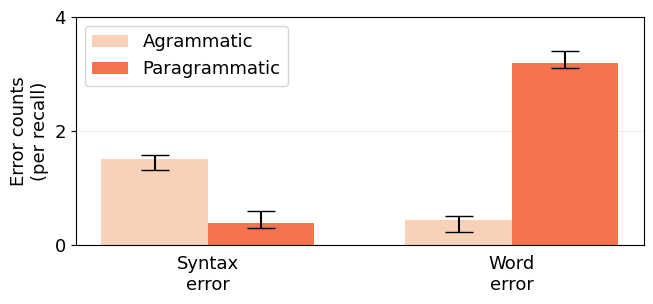

In [97]:
import matplotlib.pyplot as plt

x_pos = np.arange(2)
mean_val_A = [syn_err_mat_ag.mean(),word_err_mat_ag.mean()] # mean for sentence
mean_err_A = [stats.sem(syn_err_mat_ag),stats.sem(word_err_mat_ag)] # mean err for sentence
mean_val_B = [syn_err_mat_p.mean(),word_err_mat_p.mean()] # mean for list
mean_err_B = [stats.sem(syn_err_mat_p),stats.sem(word_err_mat_p)] # mean err for list


X_axis = ['Syntax\nerror','Word\nerror']

bar_width = 0.35
# SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
lab = ['Agrammatic','Paragrammatic']
# lab = [lab[n].translate(SUB) for n in range(2)]

font_size = 22

plt.rc('font', size=font_size) 

fig, ax = plt.subplots(figsize=(7, 3.5))

alp = 1

b1 = ax.bar(x_pos, mean_val_A,  yerr=mean_err_A, align='center', alpha=alp, ecolor='black', capsize=10, label=lab[0], color='#f7d2b9',
            width=bar_width)
b2 = ax.bar(x_pos + bar_width, mean_val_B, yerr=mean_err_B, align='center', alpha=alp, ecolor='black', capsize=10, label=lab[1], color='#f3744f',
            width=bar_width)


ax.set_ylim([0,4])
ax.set_ylabel('Error counts\n(per recall)', fontsize=13)
plt.yticks(fontsize=13)
# ax.set_xlabel('Level of Noise')
ax.set_xticks(x_pos + bar_width/2)
ax.set_xticklabels(X_axis,rotation=0, fontsize=13)
# ax.set_title('Coefficent of Thermal Expansion (CTE) of Three Metals')
ax.yaxis.grid(True)


ax.legend(loc='upper left', ncol = 1, fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# x1 = [0,bar_width]
# y1 = [12,20]
axes2 = plt.twinx()
axes2.set_yticks([])
# axes2.plot([], [], color='k', marker='D')
# axes2.set_ylim(0, 90)
# axes2.set_ylabel('Bock (1986) (%)')

# x1 = [1,1+bar_width]
# y1 = [73,65]
# axes2.plot(x1, y1, color='k', marker='D',label='Bock(1986)')
# axes2.legend(loc=0)



# Save the figure and show
plt.tight_layout()
plt.savefig('retrieving.png', transparent=True)
plt.show()

In [1]:
import colorcet as cct
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.colors as clr

aa = cjn.spec_argmax(f_act_hx_r[4:26,:15])
bb = np.int_(aa.squeeze())
bb = np.eye(15)[bb]
# bb = np.delete(bb, 8, 1)
# cc = np.zeros((bb.shape[0],5))
# bb = np.append(bb,cc,axis=1)
# bb = np.delete(bb, 0, 1)
# bb = np.delete(bb, 7, 1)
# bb.shape

df_f = pd.DataFrame(bb, columns = ['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13','f14']) #,'f5','f6'
df_f.index.name = 'time_step'

palette = sn.color_palette(cct.glasbey_hv, 14)
# palette=sn.color_palette("Paired", 14)

#4*1.25, 2
a4_dims = (4*1.25, 3.5)
fig, ax = plt.subplots(nrows=14,figsize=a4_dims)

snsplt = sn.heatmap(np.expand_dims(bb[:,0], axis=0),ax=ax[0],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[0])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])
snsplt = sn.heatmap(np.expand_dims(bb[:,1], axis=0),ax=ax[1],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[1])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])
snsplt = sn.heatmap(np.expand_dims(bb[:,2], axis=0),ax=ax[2],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[2])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])

snsplt = sn.heatmap(np.expand_dims(bb[:,3], axis=0),ax=ax[3],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[3])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])
snsplt = sn.heatmap(np.expand_dims(bb[:,4], axis=0),ax=ax[4],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[4])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])
snsplt = sn.heatmap(np.expand_dims(bb[:,5], axis=0),ax=ax[5],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[5])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])

snsplt = sn.heatmap(np.expand_dims(bb[:,6], axis=0),ax=ax[6],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[6])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])
snsplt = sn.heatmap(np.expand_dims(bb[:,7], axis=0),ax=ax[7],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[7])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])
snsplt = sn.heatmap(np.expand_dims(bb[:,8], axis=0),ax=ax[8],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[8])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])

snsplt = sn.heatmap(np.expand_dims(bb[:,9], axis=0),ax=ax[9],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[9])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])
snsplt = sn.heatmap(np.expand_dims(bb[:,10], axis=0),ax=ax[10],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[10])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])
snsplt = sn.heatmap(np.expand_dims(bb[:,11], axis=0),ax=ax[11],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[11])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])

snsplt = sn.heatmap(np.expand_dims(bb[:,12], axis=0),ax=ax[12],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[12])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])

snsplt = sn.heatmap(np.expand_dims(bb[:,13], axis=0),ax=ax[13],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
                                              (1, palette.as_hex()[13])], 2),vmin=0,vmax=1,cbar=False)
snsplt.tick_params(top = False, bottom = False,left = False, right = False)
snsplt.set_yticks([])
snsplt.set_xticks([])

# snsplt = sn.heatmap(np.expand_dims(bb[:,14], axis=0),ax=ax[14],cmap=clr.LinearSegmentedColormap.from_list('Custom', [(0,    '#dcdcdc'),
#                                               (1, palette.as_hex()[14])], 2),vmin=0,vmax=1,cbar=False)
# snsplt.tick_params(top = False, bottom = False,left = False, right = False)
# snsplt.set_yticks([])
# snsplt.set_xticks([])


# snsplt.tick_params(length=7.5)
# ax.set_yticklabels(['',''])
snsplt.tick_params(bottom = False,left = False)

snsplt.set(xlabel=None,ylabel=None)
# snsplt.get_legend().remove()

plt.savefig(fname='retrieving', transparent=True)